In [1]:
!pip install -q transformers

     |████████████████████████████████| 2.6 MB 14.5 MB/s 
     |████████████████████████████████| 3.3 MB 42.9 MB/s 
     |████████████████████████████████| 895 kB 12.8 MB/s 
     |████████████████████████████████| 636 kB 59.8 MB/s 


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
import transformers
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import AutoTokenizer, AutoModel

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report


In [3]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
np.random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)

## Load data

In [6]:
#change to where you store mimic3 data
MIMIC_3_DIR = '/content/drive/MyDrive/Colab Notebooks/MSc-Individual-Project/datasets_date'

train_df = pd.read_csv('%s/train_50_adm.csv' % MIMIC_3_DIR)
eval_df = pd.read_csv('%s/dev_50_adm.csv' % MIMIC_3_DIR)
test_df = pd.read_csv('%s/test_50_adm.csv' % MIMIC_3_DIR)

train_df.head()

,SUBJECT_ID,HADM_ID,TEXT,LABELS,length
0,15807,173079,atrial fibrillation,410.71;427.31,2
1,13019,171359,sinus rhythm normal ecg,530.81;486;511.9;599.0,4
2,49369,195429,sinus rhythm within normal limits,511.9,5
3,30374,110926,sinus rhythm within normal limits,530.81;311;599.0;428.0;410.71;507.0;518.81;997...,5
4,31660,196666,normal sinus rhythm normal ecg,530.81;401.9;496,5


In [7]:
full_df = pd.concat([train_df, eval_df, test_df], ignore_index=True)


 ## Preprocess Data

In [8]:
# split labels by ";", then convert to list
def split_lab (x):
    #print(x)
    return x.split(";")

full_df['LABELS'] = full_df['LABELS'].apply(split_lab)
#full_df['TEXT'] = full_df['TEXT'].apply(split_lab)

full_df.head()

,SUBJECT_ID,HADM_ID,TEXT,LABELS,length
0,15807,173079,atrial fibrillation,"[410.71, 427.31]",2
1,13019,171359,sinus rhythm normal ecg,"[530.81, 486, 511.9, 599.0]",4
2,49369,195429,sinus rhythm within normal limits,[511.9],5
3,30374,110926,sinus rhythm within normal limits,"[530.81, 311, 599.0, 428.0, 410.71, 507.0, 518...",5
4,31660,196666,normal sinus rhythm normal ecg,"[530.81, 401.9, 496]",5


In [9]:
#load multi label binarizer for one-hot encoding
mlb = MultiLabelBinarizer(sparse_output=True)



In [10]:
#change label to one-hot encoding per code
full_df = full_df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(full_df.pop('LABELS')),
                columns=mlb.classes_))

full_df.head()

,SUBJECT_ID,HADM_ID,TEXT,length,038.9,244.9,250.00,272.0,272.4,276.0,276.1,276.2,285.1,285.9,287.5,305.1,311,327.23,401.9,403.90,403.91,410.71,412,414.01,424.0,424.1,427.31,427.89,428.0,486,493.90,496,507.0,511.9,518.0,518.81,530.81,584.5,584.9,585.9,599.0,774.2,785.52,995.92,997.1,V05.3,V15.82,V29.0,V30.00,V30.01,V45.81,V45.82,V58.61,V58.67
0,15807,173079,atrial fibrillation,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13019,171359,sinus rhythm normal ecg,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,49369,195429,sinus rhythm within normal limits,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,30374,110926,sinus rhythm within normal limits,5,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,31660,196666,normal sinus rhythm normal ecg,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# Convert columns to list of one hot encoding
icd_classes_50 = mlb.classes_

full_df['labels'] = full_df[icd_classes_50].values.tolist()
#train_df.sort_values(['length'], ascending=False, inplace=True)
full_df


,SUBJECT_ID,HADM_ID,TEXT,length,038.9,244.9,250.00,272.0,272.4,276.0,276.1,276.2,285.1,285.9,287.5,305.1,311,327.23,401.9,403.90,403.91,410.71,412,414.01,424.0,424.1,427.31,427.89,428.0,486,493.90,496,507.0,511.9,518.0,518.81,530.81,584.5,584.9,585.9,599.0,774.2,785.52,995.92,997.1,V05.3,V15.82,V29.0,V30.00,V30.01,V45.81,V45.82,V58.61,V58.67,labels
0,15807,173079,atrial fibrillation,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,13019,171359,sinus rhythm normal ecg,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,49369,195429,sinus rhythm within normal limits,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,30374,110926,sinus rhythm within normal limits,5,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,31660,196666,normal sinus rhythm normal ecg,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11047,93290,161681,chief complaint fatigue weakness nausea vomiti...,1511,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
11048,93002,156791,admission date discharge date service medicine...,1616,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ..."
11049,89992,135343,admission date discharge date date of birth se...,1663,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, ..."
11050,96110,172107,admission date discharge date date of birth se...,1892,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


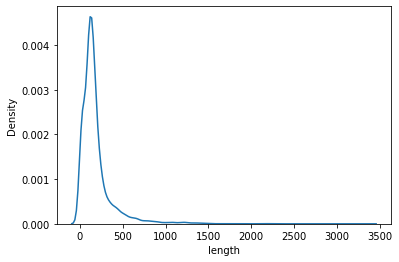

In [12]:
sns.kdeplot(full_df.length)

In [ ]:
train_df, test_df = train_test_split(full_df, test_size=0.15)
train_df, eval_df = train_test_split(train_df, test_size=0.2)

In [ ]:
train_df.sort_values(['length'], inplace=True)
eval_df.sort_values(['length'], inplace=True)
test_df.sort_values(['length'], inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#convert into 2 columns dataframe
train_df = pd.DataFrame(train_df, columns=['TEXT', 'labels'])
train_df.columns=['text', 'labels']
train_df.head()

eval_df = pd.DataFrame(eval_df, columns=['TEXT', 'labels'])
eval_df.columns=['text', 'labels']
eval_df.head()

test_df = pd.DataFrame(test_df, columns=['HADM_ID', 'TEXT', 'labels'])
test_df.columns=['id', 'text', 'labels']


In [ ]:
train_df.reset_index(drop=True, inplace=True)
eval_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df.head()

,id,text,labels
0,110926,sinus rhythm within normal limits,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,155695,sinus rhythm similar to tracing tracing,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,173700,respiratory care note this is twin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,149406,53yr female s p large l ich,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,152128,sinus tachycardia normal ecg except for rate,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."


### Set Model Parameters

In [ ]:
# Defining some key variables to configure model training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 12
VALID_BATCH_SIZE = 12
TEST_BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 3e-05

#set tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

### Preparing Dataloader

In [ ]:
#custom dataset for BERT class
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        
        '''
            set text as training data
            set labels as targets
        '''
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
#load df to dataset

training_set = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_set = CustomDataset(eval_df, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_df, tokenizer, MAX_LEN)

In [ ]:
#data loader
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True
                }

training_loader = DataLoader(training_set, **train_params)
valid_loader = DataLoader(valid_set, **val_params)
testing_loader = DataLoader(testing_set, **test_params)

### Create model class from pretrained model

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()

        self.l1 = transformers.AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", return_dict=False)
        #self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        
        
        self.l2 = torch.nn.Dropout(0.3)
        

        self.l3 = torch.nn.Linear(768, 50)
    
    def forward(self, ids, mask, token_type_ids):
#        print("ids: ", ids.size(), "mask: ", mask.size(), "token type ids: ", token_type_ids.size())
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [ ]:
#loss function
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
#optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

### Train fine-tuning model

In [ ]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')

In [ ]:
# Evaluate the model

def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    losses=[]
    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    print(f'Epoch: {epoch}, Validation Loss:  {np.mean(losses):.2f}')
    return fin_outputs, fin_targets, losses

In [ ]:
start_epoch=0
DIR = '/content/drive/MyDrive/Colab Notebooks/MSc-Individual-Project/'
resume = True     
if resume:
    if os.path.isfile(f"%s/models/models_adm_epoch{start_epoch}.pth" % DIR):
        print("Resume from checkpoint...")
        checkpoint = torch.load(f"%s/models/models_adm_epoch{start_epoch}.pth" % DIR)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        initepoch = checkpoint['epoch']
        print("====>loaded checkpoint (epoch{})".format(checkpoint['epoch']))
    else:
        print("====>no checkpoint found.")
        initepoch = 0

for epoch in tqdm(range(EPOCHS)):
    train(epoch)
    validation(epoch)

    if (epoch+start_epoch+1)%5 == 0:
        checkpoint = {"model_state_dict": model.state_dict(),
                      "optimizer_state_dict": optimizer.state_dict(),
                      "epoch": epoch+start_epoch+1}
        path_checkpoint = f"%s/models/models_adm_epoch{epoch+start_epoch+1}.pth" % DIR
        torch.save(checkpoint, path_checkpoint)




====>no checkpoint found.


  0%|          | 0/10 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Training Loss:  0.26818808913230896


 10%|█         | 1/10 [07:27<1:07:11, 447.98s/it]

Epoch: 0, Validation Loss:  0.29
Epoch: 1, Training Loss:  0.21010363101959229


 20%|██        | 2/10 [14:55<59:41, 447.72s/it]  

Epoch: 1, Validation Loss:  0.27
Epoch: 2, Training Loss:  0.29695990681648254


 30%|███       | 3/10 [22:22<52:13, 447.58s/it]

Epoch: 2, Validation Loss:  0.27
Epoch: 3, Training Loss:  0.2346341758966446


 40%|████      | 4/10 [29:50<44:45, 447.51s/it]

Epoch: 3, Validation Loss:  0.26
Epoch: 4, Training Loss:  0.4033884108066559
Epoch: 4, Validation Loss:  0.27


 50%|█████     | 5/10 [37:22<37:26, 449.34s/it]

Epoch: 5, Training Loss:  0.26675015687942505


 60%|██████    | 6/10 [44:50<29:54, 448.71s/it]

Epoch: 5, Validation Loss:  0.26
Epoch: 6, Training Loss:  0.1749815195798874


 70%|███████   | 7/10 [52:17<22:24, 448.15s/it]

Epoch: 6, Validation Loss:  0.27
Epoch: 7, Training Loss:  0.19406801462173462


 80%|████████  | 8/10 [59:44<14:55, 447.80s/it]

Epoch: 7, Validation Loss:  0.27
Epoch: 8, Training Loss:  0.3856979310512543


 90%|█████████ | 9/10 [1:07:11<07:27, 447.56s/it]

Epoch: 8, Validation Loss:  0.27
Epoch: 9, Training Loss:  0.19270522892475128
Epoch: 9, Validation Loss:  0.27


100%|██████████| 10/10 [1:14:51<00:00, 449.12s/it]



### Model Evaluation

In [ ]:

DIR = '/content/drive/MyDrive/Colab Notebooks/MSc-Individual-Project/'

checkpoint = torch.load(f"%s/models/models_adm_epoch10.pth" % DIR)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
# Evaluate the model
def testing():
    model.eval()

    fin_targets=[]
    fin_outputs=[]
    losses=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            fin_targets.extend(targets.cpu().detach().numpy())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy())
    print(f'Loss:  {np.mean(losses):.2f}')
    return fin_outputs, fin_targets, losses

In [ ]:

test_out, targets, losses = testing()
outputs = np.array(test_out) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Loss:  0.27
F1 Score (Micro) = 0.2581318160265529
F1 Score (Macro) = 0.13863807872855913


In [ ]:
ruc_auc_score_micro = metrics.roc_auc_score(targets, outputs, average='micro')
ruc_auc_score_macro = metrics.roc_auc_score(targets, outputs, average='macro')

print(f"RUC AUC Score (Micro) = {ruc_auc_score_micro}")
print(f"RUC AUC Score (Macro) = {ruc_auc_score_macro}")

RUC AUC Score (Micro) = 0.5777288835942979
RUC AUC Score (Macro) = 0.5561373864088077


In [ ]:
print(classification_report(targets, outputs, target_names=icd_classes_50, digits=4))

              precision    recall  f1-score   support

       038.9     0.2679    0.1210    0.1667       124
       244.9     0.0000    0.0000    0.0000       189
      250.00     0.0000    0.0000    0.0000       299
       272.0     0.0000    0.0000    0.0000       181
       272.4     0.3662    0.0788    0.1297       330
       276.0     0.0000    0.0000    0.0000        80
       276.1     0.0000    0.0000    0.0000       120
       276.2     0.0000    0.0000    0.0000       161
       285.1     0.5000    0.0115    0.0225       174
       285.9     0.0000    0.0000    0.0000       211
       287.5     0.0000    0.0000    0.0000       129
       305.1     0.0000    0.0000    0.0000       100
         311     0.0000    0.0000    0.0000       132
      327.23     0.0000    0.0000    0.0000        91
       401.9     0.5144    0.5281    0.5212       676
      403.90     0.0000    0.0000    0.0000       139
      403.91     0.6667    0.1379    0.2286        87
      410.71     0.0000    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
